In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import os
from glob import glob

In [3]:
base_bone_dir = os.path.join('..', 'input')
age_df = pd.read_csv(os.path.join(base_bone_dir, 'boneage-training-dataset.csv'))
age_df['path'] = age_df['id'].map(lambda x: os.path.join(base_bone_dir,
                                                         'boneage-training-dataset', 
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)

12611 images found of 12611 total


,id,boneage,male,path,exists,gender,boneage_zscore
9064,11654,126,True,../input/boneage-training-dataset/boneage-trai...,True,male,-0.016036
4397,6441,126,False,../input/boneage-training-dataset/boneage-trai...,True,female,-0.016036
7694,10106,162,True,../input/boneage-training-dataset/boneage-trai...,True,male,0.421048


In [14]:
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)
new_age_df = age_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(400, replace = True)
                                                      ).reset_index(drop = True)

In [15]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(new_age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = new_age_df['boneage_category'])
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 6000 validation 2000


In [16]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (512, 512)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 10, 
                              shear_range = 0.05,
                              fill_mode = 'nearest',
                              zoom_range=0.15)

In [17]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [10]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 64)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 64)
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 500)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images


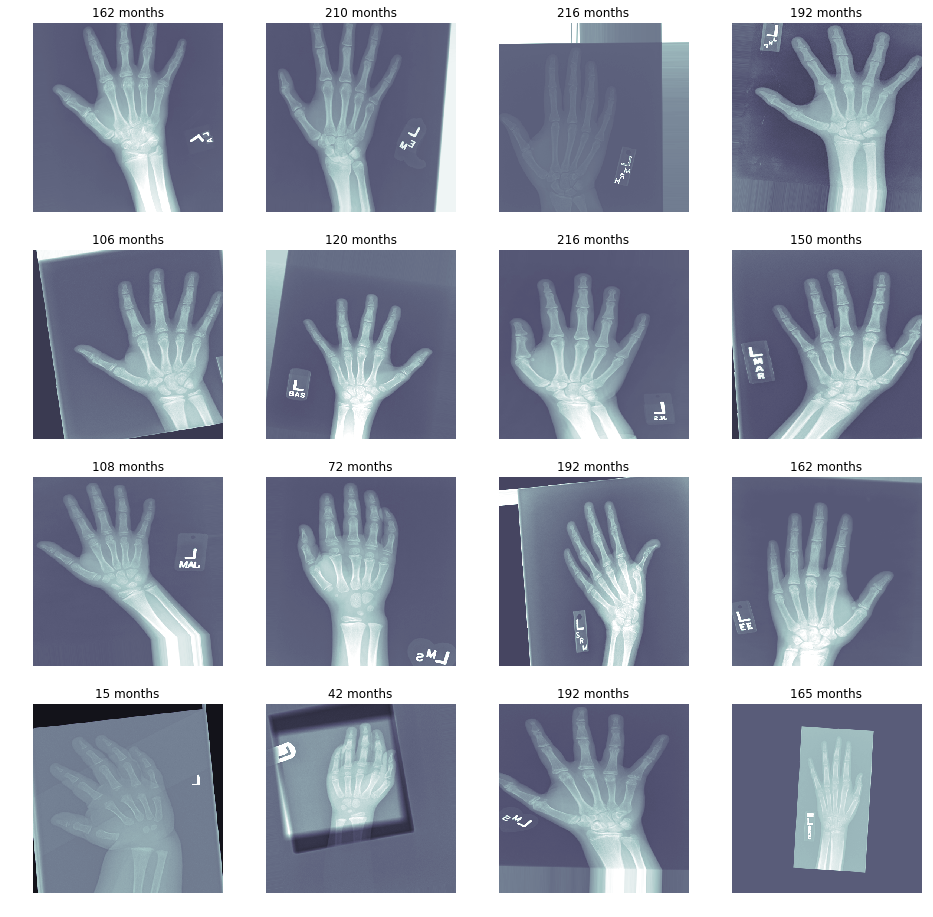

In [18]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -3, vmax = 3)
    c_ax.set_title('%2.0f months' % (c_y*boneage_div+boneage_mean))
    c_ax.axis('off')

In [19]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, 
                                 weights = None)
bone_age_model = Sequential()
bone_age_model.add(BatchNormalization(input_shape = t_x.shape[1:]))
bone_age_model.add(base_mobilenet_model)
bone_age_model.add(BatchNormalization())
bone_age_model.add(GlobalAveragePooling2D())
bone_age_model.add(Dropout(0.5))
bone_age_model.add(Dense(1, activation = 'linear' ))
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = [mae_months])

bone_age_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 512, 512, 1)       4         
_________________________________________________________________
mobilenet_1.00_512 (Model)   (None, 16, 16, 1024)      3228288   
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,233,413
Trainable params: 3,209,475
Non-trainable params: 23,938
_____________________________________________________________

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/callbacks.py:919: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.


In [21]:
train_gen.batch_size = 16
bone_age_model.fit_generator(train_gen, 
                                  validation_data = (test_X, test_Y), 
                                  epochs = 10, 
                                  callbacks = callbacks_list)

Epoch 1/10
375/375 [==============================] - 406s 1s/step - loss: 0.5409 - mae_months: 49.0073 - val_loss: 2.2563 - val_mae_months: 92.4614

Epoch 00001: val_loss improved from inf to 2.25635, saving model to bone_age_weights.best.hdf5
Epoch 2/10
375/375 [==============================] - 377s 1s/step - loss: 0.3024 - mae_months: 35.9630 - val_loss: 0.4289 - val_mae_months: 41.5373

Epoch 00002: val_loss improved from 2.25635 to 0.42893, saving model to bone_age_weights.best.hdf5
Epoch 3/10
375/375 [==============================] - 378s 1s/step - loss: 0.2191 - mae_months: 30.4031 - val_loss: 0.1759 - val_mae_months: 26.8889

Epoch 00003: val_loss improved from 0.42893 to 0.17589, saving model to bone_age_weights.best.hdf5
Epoch 4/10
375/375 [==============================] - 376s 1s/step - loss: 0.1678 - mae_months: 26.8595 - val_loss: 0.1167 - val_mae_months: 22.0261

Epoch 00004: val_loss improved from 0.17589 to 0.11670, saving model to bone_age_weights.best.hdf5
Epoch 5/

In [25]:
bone_age_model.load_weights(weight_path)

In [26]:
pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 16, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

500/500 [==============================] - 4s 7ms/step


Text(0,0.5,'Predicted Age (Months)')

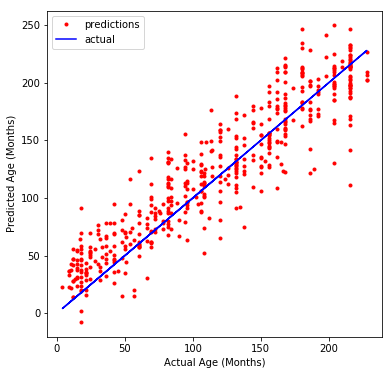

In [27]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')